In [9]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import json
import joblib as joblib

import re
import string
import dill

In [10]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [11]:
# Load data
data_train = pd.read_csv('../../Data Splits/train_data_70_30.csv')
data_val = pd.read_csv('../../Data Splits/val_data_70_30.csv')

In [12]:
X_train = data_train['article']
y_train = data_train['label']

X_val = data_val['article']
y_val = data_val['label']

In [13]:
# Stopword Removal
ps = PorterStemmer()
with open('../../Datasets/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

# Custom transformer for text preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join(self.preprocess(text)) for text in X]
    
    def preprocess(self, text):
        # Lowercase Conversion
        lowered = text.lower()

        # URL Removal
        urled = re.sub(r'https?://\S+|www\.\S+', '', lowered)
        
        # Text Simplification
        text = re.sub(r'\[.*?\]', '', urled)
        text = re.sub(r"\\W", " ", text)
        text = re.sub(r'<.*?>+', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\w*\d\w*', '', text)

        # Tokenization
        tokens = nltk.word_tokenize(text)
        stems = [ps.stem(token) for token in tokens]
        filtered = [stem for stem in stems if stem not in stopwords]
        return filtered

In [15]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

In [20]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1, 2, 3, 4, 'sqrt', 'log2']
}


In [21]:
# Define the steps in your pipeline
steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer()),
    ('gridsearch', GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1))

]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer', TfidfVectorizer()),
                ('gridsearch',
                 GridSearchCV(cv=5, estimator=RandomForestClassifier(),
                              n_jobs=-1,
                              param_grid={'max_depth': [None, 10, 20, 30],
                                          'max_features': [1, 2, 3, 4, 'sqrt',
                                                           'log2'],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [100, 200, 300]},
                              scoring='accuracy'))])

In [22]:
best_meta = pipeline.named_steps['gridsearch'].best_estimator_
joblib.dump(pipeline.named_steps['gridsearch'] , '../../ModelsV2/pipeline_rf_gridsearch.joblib')


['../../ModelsV2/pipeline_rf_gridsearch_combined.joblib']

In [23]:
print("Best Hyperparameters: ", pipeline.named_steps['gridsearch'].best_params_)
print("Best Accuracy: {:.2f}%".format(pipeline.named_steps['gridsearch'].best_score_ * 100))

Best Hyperparameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best Accuracy: 93.55%


In [24]:
stack = StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta, cv=5)
stack.fit(X_train, y_train)
stack = Pipeline(steps)

StackingClassifier(cv=5,
                   estimators=[('MNB', MultinomialNB()),
                               ('LR', LogisticRegression()),
                               ('RF', RandomForestClassifier()),
                               ('KNN', KNeighborsClassifier()),
                               ('SVM', SVC(probability=True))],
                   final_estimator=RandomForestClassifier(min_samples_split=5,
                                                          n_estimators=300))

In [ ]:

# # Create an empty DataFrame for storing metrics
# metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# # Use TFIDF inside of stacking to vectorize X_val(Evaluation)
# # vectorized_text = stack.named_steps['vectorizer'].transform(X_val)

# # Evaluate base models
# for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
#     y_pred = model.predict(X_val_tfidf)
#     y_prob = model.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve
    
#     accuracy = accuracy_score(y_val, y_pred)
#     precision = precision_score(y_val, y_pred)
#     recall = recall_score(y_val, y_pred)
#     f1 = f1_score(y_val, y_pred)
#     auc = roc_auc_score(y_val, y_prob)

#     print(f"Metrics for {name}:")
#     print(f"Accuracy: {accuracy}")
#     print(f"Precision: {precision}")
#     print(f"Recall: {recall}")
#     print(f"F1 Score: {f1}")
#     print(f"AUC: {auc}")
#     print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

#     # Store metrics in the DataFrame
#     metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

#     # ROC Curve
#     fpr, tpr, _ = roc_curve(y_val, y_prob)
#     roc_auc = roc_auc_score(y_val, y_prob)

#     # Plot ROC Curve
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(f'ROC Curve - {name}')
#     plt.legend(loc="lower right")
#     plt.show()

Metrics for MNB:
Accuracy: 0.8386699507389163
Precision: 0.7628083491461101
Recall: 0.9852941176470589
F1 Score: 0.8598930481283422
AUC: 0.9788147932440303
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       404
           1       0.76      0.99      0.86       408

    accuracy                           0.84       812
   macro avg       0.87      0.84      0.83       812
weighted avg       0.87      0.84      0.84       812



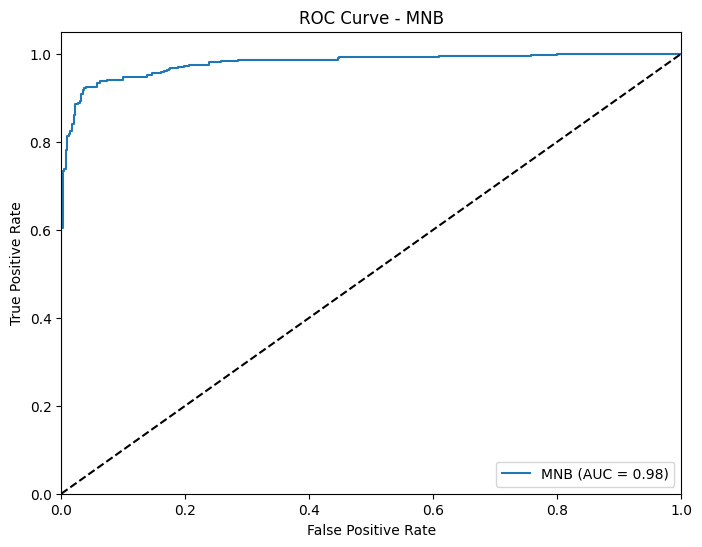

Metrics for LR:
Accuracy: 0.9334975369458128
Precision: 0.9633507853403142
Recall: 0.9019607843137255
F1 Score: 0.9316455696202531
AUC: 0.9862041351193942
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       404
           1       0.96      0.90      0.93       408

    accuracy                           0.93       812
   macro avg       0.94      0.93      0.93       812
weighted avg       0.94      0.93      0.93       812



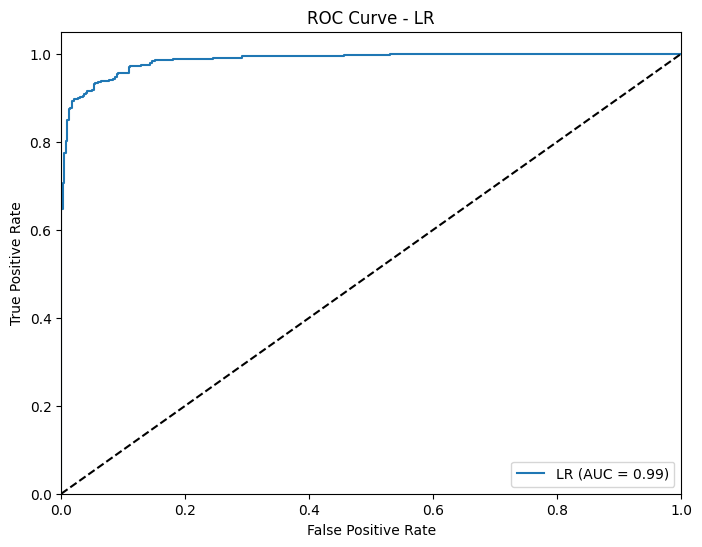

Metrics for RF:
Accuracy: 0.9396551724137931
Precision: 0.9544303797468354
Recall: 0.9240196078431373
F1 Score: 0.9389788293897883
AUC: 0.985846194913609
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       404
           1       0.95      0.92      0.94       408

    accuracy                           0.94       812
   macro avg       0.94      0.94      0.94       812
weighted avg       0.94      0.94      0.94       812



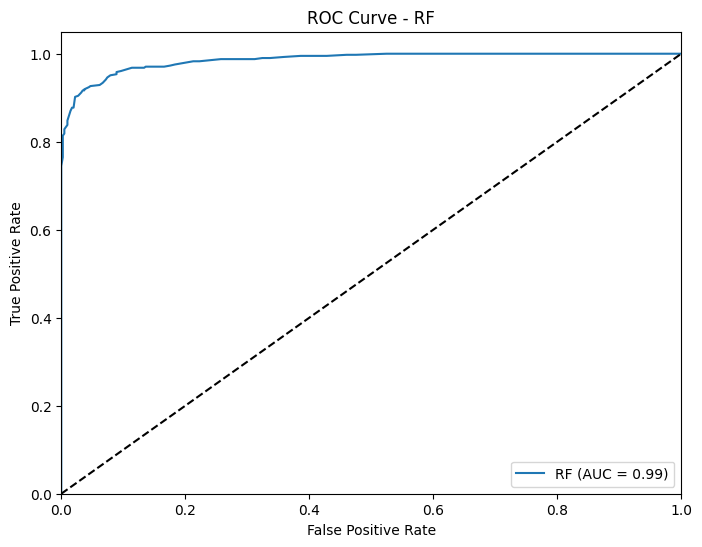

Metrics for KNN:
Accuracy: 0.8768472906403941
Precision: 0.8290598290598291
Recall: 0.9509803921568627
F1 Score: 0.8858447488584474
AUC: 0.9450258444962144
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       404
           1       0.83      0.95      0.89       408

    accuracy                           0.88       812
   macro avg       0.89      0.88      0.88       812
weighted avg       0.89      0.88      0.88       812



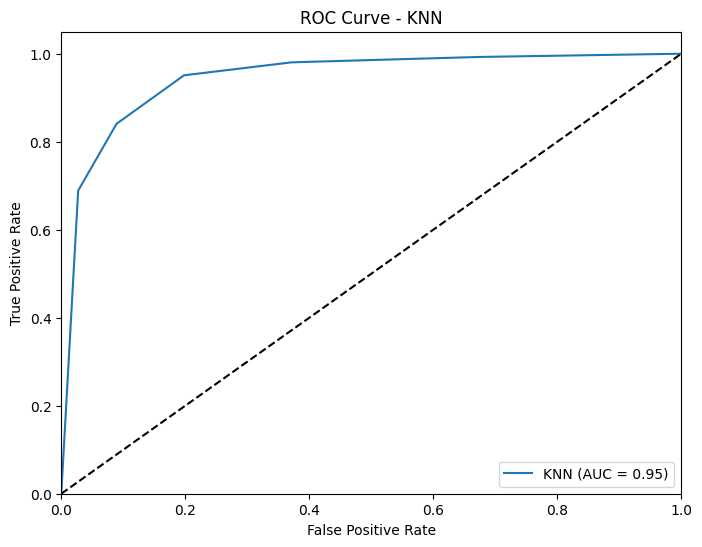

Metrics for SVM:
Accuracy: 0.9433497536945813
Precision: 0.9763157894736842
Recall: 0.9093137254901961
F1 Score: 0.9416243654822335
AUC: 0.9891465249466123
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       404
           1       0.98      0.91      0.94       408

    accuracy                           0.94       812
   macro avg       0.95      0.94      0.94       812
weighted avg       0.95      0.94      0.94       812



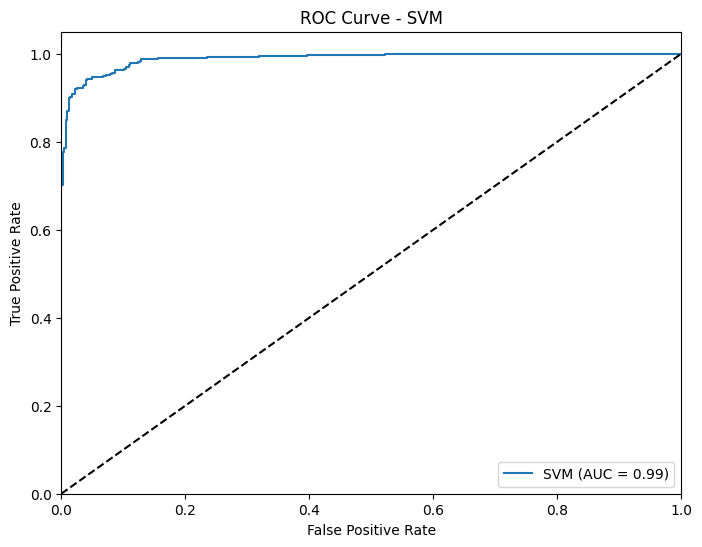

In [27]:
# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])


# Evaluate base models
for model, name in zip(base_models, base_names):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    y_prob = model.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

In [30]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_val)
stack_y_prob = stack.predict_proba(X_val)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_val, stack_y_pred)
stack_precision = precision_score(y_val, stack_y_pred)
stack_recall = recall_score(y_val, stack_y_pred)
stack_f1 = f1_score(y_val, stack_y_pred)
stack_auc = roc_auc_score(y_val, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

ValueError: X has 28298 features, but MultinomialNB is expecting 5 features as input.

In [ ]:
# Save the model using joblib
joblib.dump(stack, '../../ModelsV2/pipeline_rf_combined.joblib')

with open('../../ModelsV2/pipeline_rf_combined.pkl', 'wb') as f:
    dill.dump(stack, f)